## 测量因子

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import single

from Utility.factorFactory import FactorFactory
from Utility.Util import evaluate_time_series_ic
import matplotlib.pyplot as plt

### （1）预处理数据：

In [2]:
df = pd.read_csv ('df_minute.csv')
df.shape

(1920, 16)

In [3]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dollar_volume',
       'vwap', 'tick_count', 'trade_size_mean', 'trade_size_std',
       'zero_return_count', 'price_direction_ratio', 'large_trade_count',
       'large_trade_ratio', 'large_trade_volume_ratio'],
      dtype='object')

In [4]:
finfact = FactorFactory (df, forward_period=5, window=100, scaler='minmax', top_k=10)

In [5]:
finfact.generate_factors (mode='thread', n_job=4, bounded_only=True)
df_featured = finfact.df_features
df_featured.shape

🔄 cross_op (thread): 100%|██████████| 4802/4802 [00:00<00:00, 640598.19it/s]


(1901, 5048)

### （3）评测因子：

In [14]:
finfact.get_summary ()

,spearman_ic,pearson_ir,pca_coeff,spearman_ic_norm,pearson_ir_norm,pca_coeff_norm,combined_score
rsi_14_large_trade_volume_ratio_minus_rsi_10_close,0.0832,1.2841,0.0828,0.9782,0.9626,0.9712,2.9120
rsi_14_price_direction_ratio_minus_rsi_10_close,0.0839,1.3086,0.0815,0.9825,0.9715,0.9564,2.9104
rsi_14_large_trade_ratio_minus_rsi_10_close,0.0811,1.3001,0.0830,0.9659,0.9684,0.9734,2.9078
bb_pband_10_1.5_minus_rsi_10_close,0.0807,1.2924,0.0833,0.9638,0.9656,0.9769,2.9063
bb_pband_10_2.0_minus_rsi_10_close,0.0803,1.2906,0.0834,0.9614,0.9649,0.9778,2.9041
bb_pband_20_2.0_minus_rsi_10_close,0.0792,1.2885,0.0835,0.9551,0.9642,0.9790,2.8983
bb_pband_20_1.5_minus_rsi_10_close,0.0791,1.2897,0.0834,0.9550,0.9646,0.9785,2.8981
rsi_14_large_trade_ratio_minus_rsi_14_close,0.0779,1.3871,0.0773,0.9479,1.0000,0.9064,2.8543
bb_pband_10_2.0_minus_rsi_14_close,0.0779,1.3708,0.0778,0.9475,0.9941,0.9123,2.8539
bb_pband_10_1.5_minus_rsi_14_close,0.0780,1.3726,0.0776,0.9486,0.9947,0.9099,2.8533


In [7]:
cur_features = finfact.next(steps=10, k=10, mode='thread', n_job=4, bounded_only=True)

🔄 next steps: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


In [8]:
df_features = finfact.df_features
df_features

,timestamp,rsi_14_large_trade_volume_ratio_minus_rsi_10_close,rsi_14_price_direction_ratio_minus_rsi_10_close,rsi_14_large_trade_ratio_minus_rsi_14_close,bb_pband_10_1.5_minus_rsi_14_close,bb_pband_20_2.0_minus_rsi_10_close,rsi_14_large_trade_ratio_minus_rsi_10_close,bb_pband_10_1.5_minus_rsi_10_close,bb_pband_10_2.0_minus_rsi_14_close,bb_pband_10_2.0_minus_rsi_10_close,...,bb_pband_10_2.0_minus_rsi_10_close_minus_bb_pband_20_1.5_minus_rsi_10_close,bb_pband_20_1.5_minus_rsi_10_close_minus_rsi_14_large_trade_volume_ratio_minus_rsi_10_close,bb_pband_20_1.5_minus_rsi_10_close_minus_rsi_14_price_direction_ratio_minus_rsi_10_close,bb_pband_20_1.5_minus_rsi_10_close_minus_rsi_14_large_trade_ratio_minus_rsi_14_close,bb_pband_20_1.5_minus_rsi_10_close_minus_bb_pband_10_1.5_minus_rsi_14_close,bb_pband_20_1.5_minus_rsi_10_close_minus_bb_pband_20_2.0_minus_rsi_10_close,bb_pband_20_1.5_minus_rsi_10_close_minus_rsi_14_large_trade_ratio_minus_rsi_10_close,bb_pband_20_1.5_minus_rsi_10_close_minus_bb_pband_10_1.5_minus_rsi_10_close,bb_pband_20_1.5_minus_rsi_10_close_minus_bb_pband_10_2.0_minus_rsi_14_close,bb_pband_20_1.5_minus_rsi_10_close_minus_bb_pband_10_2.0_minus_rsi_10_close
0,2025-05-05 06:30:00-04:00,22.2446,9.4630,21.1952,-42.8179,-40.9576,23.1328,-40.8803,-42.7671,-40.8296,...,0.2214,-63.2956,-50.5140,-62.2462,1.7669,-0.0934,-64.1838,-0.1707,1.7161,-0.2214
1,2025-05-05 06:31:00-04:00,19.5177,18.5931,14.3276,-34.0270,-28.7170,19.5086,-28.8460,-33.8388,-28.6578,...,0.2670,-48.4425,-47.5179,-43.2524,5.1022,-0.2078,-48.4334,-0.0788,4.9140,-0.2670
2,2025-05-05 06:32:00-04:00,33.3549,21.6790,27.1589,-34.5986,-29.8049,31.9115,-29.8461,-34.4585,-29.7059,...,0.2722,-63.3330,-51.6571,-57.1370,4.6205,-0.1732,-61.8896,-0.1320,4.4804,-0.2722
3,2025-05-05 06:33:00-04:00,9.1480,7.8481,16.4327,-42.6826,-42.3206,16.8911,-42.2241,-42.6439,-42.1854,...,0.2190,-51.5524,-50.2525,-58.8371,0.2782,-0.0838,-59.2955,-0.1803,0.2395,-0.2190
4,2025-05-05 06:34:00-04:00,-4.3600,-2.7166,-2.5837,-49.1833,-51.7195,-4.8066,-51.4062,-49.2649,-51.4878,...,0.2273,-47.3551,-48.9985,-49.1314,-2.5318,0.0044,-46.9085,-0.3089,-2.4502,-0.2273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,2025-05-06 19:56:00-04:00,-15.4335,-10.0326,-12.8964,-59.3299,-61.5273,-15.0371,-61.4706,-59.4218,-61.5626,...,-0.1390,-45.9901,-51.3910,-48.5272,-2.0937,0.1037,-46.3865,0.0470,-2.0018,0.1390
1767,2025-05-06 19:57:00-04:00,-3.0417,-3.4830,-2.6077,-53.3615,-52.1162,-1.5865,-52.3402,-53.3300,-52.3088,...,-0.2254,-49.0417,-48.6004,-49.4757,1.2781,0.0328,-50.4969,0.2568,1.2466,0.2254
1768,2025-05-06 19:58:00-04:00,-8.9000,-3.4345,-10.6816,-53.7217,-52.5636,-9.8091,-52.8492,-53.6728,-52.8003,...,-0.2668,-43.6335,-49.0990,-41.8519,1.1882,0.0301,-42.7244,0.3157,1.1393,0.2668
1769,2025-05-06 19:59:00-04:00,-11.5024,-8.7185,-6.6465,-58.0060,-59.4203,-8.0559,-59.4154,-58.0895,-59.4989,...,-0.1883,-47.8082,-50.5921,-52.6641,-1.3046,0.1097,-51.2547,0.1048,-1.2211,0.1883


🔄 降维算法: 100%|██████████| 4/4 [00:24<00:00,  6.17s/it]


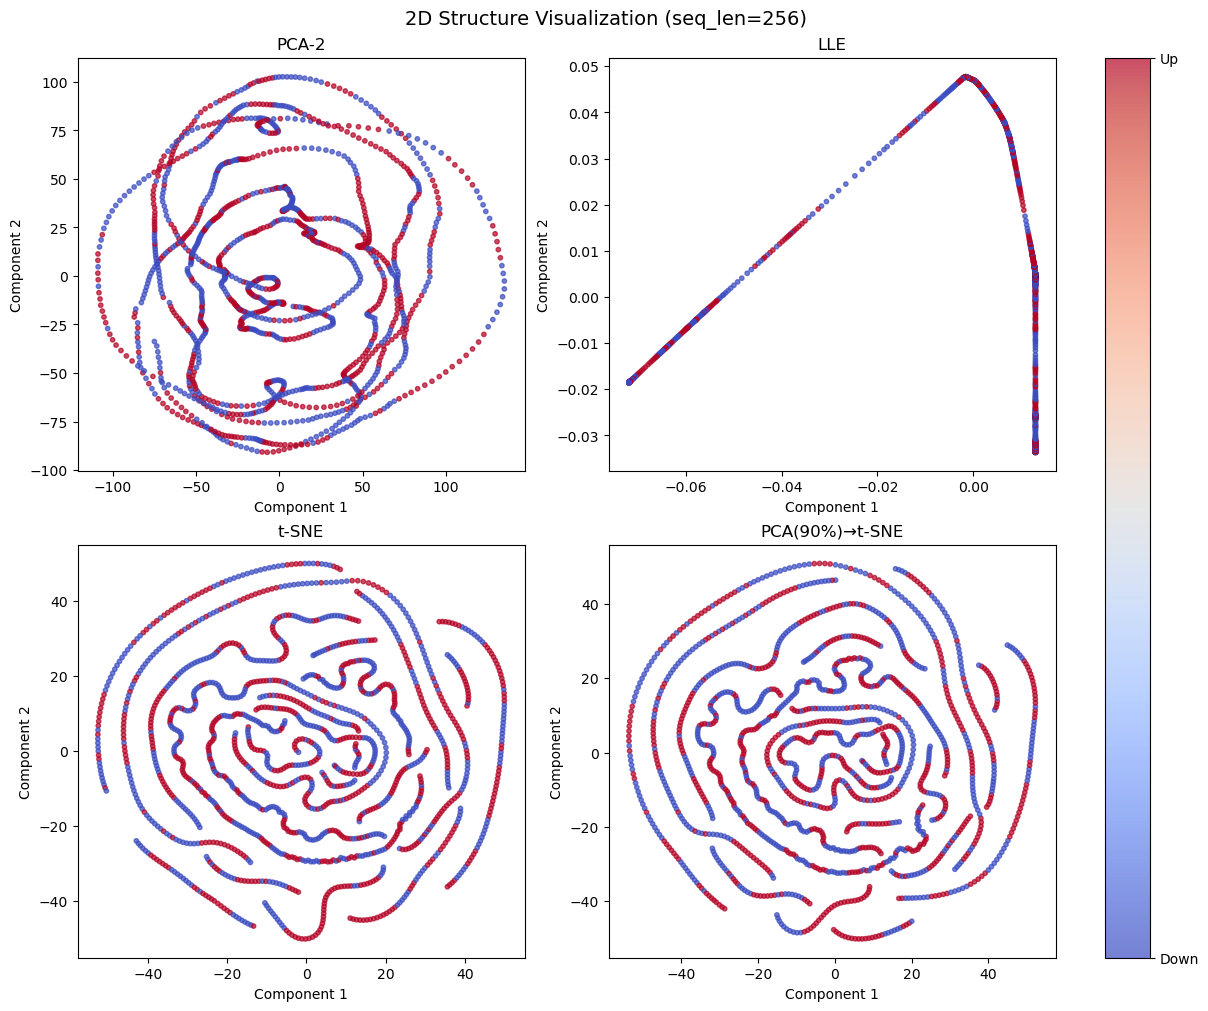

In [13]:
finfact.visualize_structure_2d (seq_len=256,
                                perplexity=50,
                                n_neighbors=5,
                                random_state=42)

In [ ]:
finfact.filter(k=100,corr_combine='average')

In [ ]:
finfact.visualize_structure_2d (target_col='close',
                                lle_n_neighbors=10,
                                tsne_perplexity=30,
                                forward=5,
                                random_state=42)

In [ ]:
finfact.evaluate_factors(forward_period=5, window=100, top_k=1000)
summary = finfact.get_ic_summary(sort_by='spearman_ic', by_abs=True)

In [ ]:
summary

#### IC分析

#### 相关性检测

In [ ]:
df_filtered = finfact.df_features.set_index('timestamp')

In [ ]:
corr = pd.DataFrame (df_filtered).corr ()
plt.figure (figsize=(12, 10))
sns.heatmap (corr, cmap='coolwarm', center=0)
plt.title ('Feature Correlation Matrix')
plt.show ()

#### PCA分析

In [ ]:
from sklearn.decomposition import PCA

pca = PCA ()
pca.fit (df_filtered)
percent = 0.99

cumulative = np.cumsum (pca.explained_variance_ratio_)
n_PCs = np.argmax (cumulative >= percent) + 1

print (f"前 {n_PCs} 个主成分累计解释了 {cumulative[n_PCs - 1]:.2%} 的方差")
feature_names = df_featured.columns

# 打印所有有重大贡献的主成分
for i in range (n_PCs):
    # 第 i 个主成分的系数
    pc = pca.components_[i]

    # 取绝对值最大的特征位置
    top_feature_idx = np.argmax (np.abs (pc))
    top_feature_name = feature_names[top_feature_idx]

    print (f"PC{i + 1} 的主导因子是: {top_feature_name}（贡献系数: {pc[top_feature_idx]:.4f}）")